### [1]. IMPORTING NECESSARY LIBRARIES AND FILES

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import PreprocessingFile #A python file to preprocess text data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### [2]. IMPORTING DATASET USING PANDAS

In [3]:
col_names = ['Text', 'Label']
train_data = pd.read_csv('Train.csv', names= col_names)
test_data = pd.read_csv('Test.csv', names= col_names)

In [4]:
#Removing first row with headings
train_data.drop(0, axis=0,inplace=True)
test_data.drop(0, axis=0,inplace=True)

In [5]:
#Check the first 5 rows of the pandas dataframe
train_data.head()

,Text,Label
1,I grew up (b. 1965) watching and loving the Th...,0
2,"When I put this movie in my DVD player, and sa...",0
3,Why do people who do not know what a particula...,0
4,Even though I have great interest in Biblical ...,0
5,Im a die hard Dads Army fan and nothing will e...,1


### [3]. PREPROCESSING THE DATASET

In [6]:
#Extractinng train data into lists
train_text = train_data.Text.tolist()

train_label = train_data.Label.tolist()


#Extracting test data into lists 
test_text = test_data.Text.tolist()

test_label = test_data.Label.tolist()

In [7]:
#Converting the labels into integers
for i in range(len(train_label)):
    train_label[i] = int(train_label[i])
    
for i in range(len(test_label)):
    test_label[i] = int(test_label[i])

In [8]:
train_label[:10]

[0, 0, 0, 0, 1, 0, 1, 0, 1, 1]

In [10]:
# preprocessing the text data in train and test dataset
preprocessed_text_train = PreprocessingFile.preprocess_list(train_text)
 
preprocessed_text_test =  PreprocessingFile.preprocess_list(test_text)

Preprocessing: 100%|██████████| 5000/5000 [00:06<00:00, 771.38it/s]


In [11]:
# Checking the length of each review i.e. no. of words per review
text_split_train = [text.split() for text in preprocessed_text_train]
text_length_train = [len(words) for words in text_split_train]

In [12]:
# Checking for maximum length of a review in the Train dataset
# print(text_length_train)
print(max(text_length_train))

1449


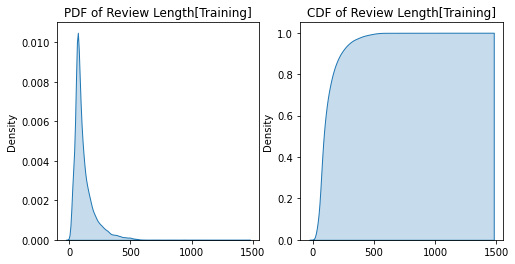

In [13]:
# Visualizing Distribution of length of reviews 
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(text_length_train, shade=True, ax=ax1)
plt.xlabel('')
plt.title("PDF of Review Length[Training]")

ax2 = plt.subplot(122)
sns.kdeplot(text_length_train, shade=True, cumulative=True,ax=ax2)
plt.xlabel('')
plt.title('CDF of Review Length[Training]')

plt.show()

In [14]:
top_words = 20000              
max_length = 500
trunc_type = 'post'
oov_tok = '<OOV>'

In [15]:
#Tokenizing the text data in train and test dataset
tokenizer = Tokenizer(num_words=top_words, oov_token=oov_tok)
tokenizer.fit_on_texts(preprocessed_text_train)

sequences = tokenizer.texts_to_sequences(preprocessed_text_train)
#padding on tokenized train data
train_padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(preprocessed_text_test)
#padding on tokenized test data
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [16]:
#Check the final shape of text data
train_padded.shape, test_padded.shape

((40000, 500), (5000, 500))

In [25]:
#Converting the train and test labels into One hot encoded vectors
train_label = tf.keras.utils.to_categorical(train_label, num_classes=2)
test_label  = tf.keras.utils.to_categorical(test_label, num_classes=2)


### [4]. MODEL BUILDING

##### [4a]. INITIALIZING NEURAL NETWORK

In [18]:
#Format: NeuralNetwork[['no._of_features', 'no._of_neurons_in_each_layers', 'no._of_class_labels']] 

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers           #Feeding layers into layers variable
        self.L = len(layers)           #No. of layers
        self.num_features = layers[0]  #Number of features
        self.num_classes  = layers[-1] #Number of class labels

        self.W = {} 
        self.b = {}

        self.dW = {}
        self.db = {}

        self.setup()
    
    def setup(self):
        for i in range(1, self.L):   #Looping over each layer
            self.W[i] = tf.Variable(tf.random.normal(shape = (self.layers[i], self.layers[i-1])))  #Initializing the weights with normal distribution
            self.b[i] = tf.Variable(tf.random.normal(shape = (self.layers[i], 1)))                 #Initializing the biases with normal distribution

##### [4b]. FORWARD PROPAGATION

In [19]:
class NeuralNetwork(NeuralNetwork):
    def forward_pass(self, X):
        A = tf.convert_to_tensor(X, dtype=tf.float32)    #Converting input to tensor
        for i in range(1, self.L):
            Z = tf.matmul(A, tf.transpose(self.W[i])) + tf.transpose(self.b[i])    #Z = W^T * X + b
            if i != self.L-1:
                A = tf.nn.relu(Z)   #Using ReLu activation for each hidden layer
            else:
                A = Z
        return A

##### [4c]. COMPUTING LOSS AND UPDATING PARAMETERS

In [20]:
class NeuralNetwork(NeuralNetwork):
    def compute_loss(self, A, Y):
        loss = tf.nn.softmax_cross_entropy_with_logits(Y, A) 
        return tf.reduce_mean(loss)      #Since the inputs will be in batches, thus taking mean of all losses

    def update_params(self, lr):
        for i in range(1, self.L):
            self.W[i].assign_sub(lr * self.dW[i])     #W[i](new) = W[i](old) - lr * (dL/dW)
            self.b[i].assign_sub(lr * self.db[i])     #b[i](new) = b[i](old) - lr * (dL/db)
            

##### [4d]. PREDICTION ON TEST DATASET

In [21]:
class NeuralNetwork(NeuralNetwork):
    def predict(self, X):
        A = self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A), axis=1)  #Using softmax layer to predict the class label

    def info(self):     #Information of no. of layers and no. of trainable params
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0] * self.b[i].shape[1]
        print('Input Features:', self.num_features)
        print('Number of Classes', self.num_classes)
        print('Hidden Layers:')
        print('---------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('----------------')
        print('Number of parameters:', num_params)

##### [4e]. TRAINING OF BATCH

In [22]:
class NeuralNetwork(NeuralNetwork):
    def train_on_batch(self, X, Y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float32)      #Convertin input vector to tensor
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)      #Convertin ouput vector to tensor

        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        for i in range(1, self.L):
            self.dW[i] = tape.gradient(loss, self.W[i])    #Finding the gradient (dL/dW) to update the weights
            self.db[i] = tape.gradient(loss, self.b[i])    #Finding the gradient (dL/db) to update the biases
        del tape
        self.update_params(lr)
        return loss.numpy()      


##### [4f]. TRAINING ON COMPLETE DATASET

In [24]:
class NeuralNetwork(NeuralNetwork):
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        history = {
            'val_loss': [],
            'train_loss': [],
            'val_acc': []
        }

        for e in range(0, epochs):
            epoch_train_loss = 0
            print('Epoch {}'.format(e), end='.')
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]     #Creating batches from train dataset
                y_batch = y_train[i*batch_size:(i+1)*batch_size]     #Creating batches from test dataset

                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss

                if i%int(steps_per_epoch/10) == 0:
                    print(end='.')
            
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)    #Updating the train_loss after each epoch
            val_A = self.forward_pass(x_test)
            val_loss = self.compute_loss(val_A, y_test).numpy()
            history['val_loss'].append(val_loss)                              #Updating the test_loss/validation_loss after each epoch           
            val_preds = self.predict(x_test)
            val_acc = np.mean(np.argmax(y_test, axis=1) == val_preds.numpy()) 
            history['val_acc'].append(val_acc)                                ##Updating the validation_accuracy after each epoch
            print('Val acc:',val_acc)

        return history

In [31]:
net = NeuralNetwork([500, 100, 80, 60, 50, 2])  
net.info()

Input Features: 500
Number of Classes 2
Hidden Layers:
---------------
Layer 1, Units 100
Layer 2, Units 80
Layer 3, Units 60
Layer 4, Units 50
----------------
Number of parameters: 66192


In [32]:
batch_size = 120
epochs = 5
steps_per_epoch = int(train_padded.shape[0]/batch_size)
lr = 3e-3

In [33]:
history = net.train(
    train_padded, train_label,
    test_padded, test_label,
    epochs, steps_per_epoch,
    batch_size, lr
)

Epoch 0............Val acc: 0.499
Epoch 1............Val acc: 0.499
Epoch 2............Val acc: 0.499
Epoch 3............Val acc: 0.499
Epoch 4............Val acc: 0.499


In [34]:
preds = net.predict(test_padded)

In [35]:
preds

<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int64)>